### Indexing and Selecting Data
- Select data by position using `.isel`
- Select data by label using  and Use nearest-neighbor lookups `.sel`

| Dimension lookup | Index lookup | `DataArray` syntax   |   `Dataset` syntax   |
| ---------------- | ------------ | ---------------------| ---------------------|
| Positional       | By integer   | `da[:,0]`            | *not available*      |
| Positional       | By label     | `da.loc[:,'IA']`     | *not available*      |
| By name          | By integer   | `da.isel(space=0)` or `da[dict(space=0)]`  | `ds.isel(space=0)` or  `ds[dict(space=0)]`  |
| By name          | By label     | `da.sel(space='IA')` or `da.loc[dict(space='IA')]` | `ds.sel(space='IA')` or `ds.loc[dict(space='IA')]` |

### **NumPy 배열 (`np_array[]`)**
- NumPy scalar 또는 array를 반환
- **위치 기반 인덱싱**만 가능
- 순수한 수치 데이터만 제공

### **xarray DataArray (`da[]`)**
- **메타데이터가 포함된** xarray.DataArray 객체를 반환
- **위치 기반 + 라벨 기반** 인덱싱 모두 가능
- 좌표, 차원명, 속성 정보를 함께 유지

---

## xarray DataArray의 주요 장점

### 1. **실수 방지 및 코드 가독성 향상**

#### NumPy의 문제점
```python
# 인덱스 순서와 의미를 모두 외워야 함
temperature_value = np_array[5, 23, 45]  
```

#### xarray의 해결책
```python
# 명확하고 직관적인 라벨 기반 선택
temperature_value = da.sel(
    time='2024-01-05', 
    lat=35.5, 
    lon=127.0
)
# 서울(위도 35.5, 경도 127.0)의 2024년 1월 5일 온도값 - 실수할 가능성 최소화
```

**자동 정렬 기능**도 제공하여 서로 다른 좌표계의 데이터를 연산할 때 자동으로 매칭

---

### 2. **연구 재현성 (Reproducibility)**

#### NumPy 코드의 모호함
```python
# 이 숫자들이 무엇을 의미하는지 알기 어려움
result = np_array[0:90, 120:160, :]  
# 90? 120? 160? 무슨 단위? 무슨 의미?
```

#### xarray의 명확성
```python
# 누구나 이해 가능한 자기 설명적 코드
result = da.sel(
    time=slice('2024-01', '2024-03'), 
    lat=slice(30, 40)
)
# "2024년 1월부터 3월까지, 위도 30-40도 구간의 데이터"라는 의미가 명확
```

이는 **연구 결과를 공유**하거나 **나중에 코드를 다시 볼 때** 매우 중요한 장점.

---

### 3. **메타데이터 보존**

데이터의 단위, 설명 등 중요한 정보가 계산 과정에서도 유지됩니다.

```python
# 원본 데이터에 단위 정보 추가
da.attrs['units'] = 'degrees_celsius'
da.attrs['description'] = 'Surface temperature'

# 계산 수행
da_fahrenheit = da * 9/5 + 32

# 새로운 단위 정보 업데이트
da_fahrenheit.attrs['units'] = 'degrees_fahrenheit'
da_fahrenheit.attrs['description'] = 'Surface temperature (converted)'

# 나중에 결과를 해석할 때 매우 유용
print(f"Temperature: {da_fahrenheit.values} {da_fahrenheit.attrs['units']}")
```

---

## NumPy 배열을 사용해야 하는 경우

### 1. **속도가 극도로 중요한 경우**

특히 대규모 반복문에서 미세한 성능 차이가 누적될 때:

```python
for i in range(1000000):
    # NumPy: 더 빠름
    value = np_array[i, j, k]
    
    # xarray: 약간 느림 (메타데이터 처리 오버헤드)
    value = da.isel(time=i, lat=j, lon=k).values
```

### 2. **NumPy/SciPy 전용 함수 사용**

일부 특수 함수들은 순수 NumPy 배열을 요구:

```python
from scipy import signal
from scipy.optimize import minimize

# SciPy 함수에는 .data로 원시 배열 전달
filtered = signal.convolve2d(da.data, kernel)
result = minimize(objective_function, da.data.flatten())
```

### 3. **복잡한 수치 계산**

고도로 최적화된 수치 알고리즘이나 커스텀 연산을 수행할 때:

```python
# 복잡한 행렬 연산이나 커스텀 알고리즘
eigenvalues = np.linalg.eig(da.data)
custom_result = advanced_numerical_algorithm(da.data)
```

---

### **권장 워크플로우**

```python
# 1️데이터 로드 및 전처리: xarray 사용
ds = xr.open_dataset('data.nc')
da = ds['temperature']

# 2️데이터 선택 및 기본 연산: xarray 유지
subset = da.sel(time='2024', lat=slice(30, 40))
monthly_mean = subset.resample(time='1M').mean()

# 3️특수 계산이 필요한 경우만 NumPy 전환
if need_special_computation:
    raw_values = monthly_mean.data
    special_result = complex_numpy_operation(raw_values)
    
    # 4 결과를 다시 DataArray로 포장
    result_da = xr.DataArray(
        special_result,
        coords=monthly_mean.coords,
        dims=monthly_mean.dims,
        attrs={'operation': 'special computation'}
    )
```

In [1]:
import xarray as xr
xr.set_options(display_expand_attrs = False, display_expand_data = False)

In [2]:
# National Center for Environmental Prediction
ds = xr.tutorial.load_dataset("air_temperature")
ds

<xarray.Dataset> Size: 31MB
Dimensions:  (lat: 25, time: 2920, lon: 53)
Coordinates:
  * lat      (lat) float32 100B 75.0 72.5 70.0 67.5 65.0 ... 22.5 20.0 17.5 15.0
  * lon      (lon) float32 212B 200.0 202.5 205.0 207.5 ... 325.0 327.5 330.0
  * time     (time) datetime64[ns] 23kB 2013-01-01 ... 2014-12-31T18:00:00
Data variables:
    air      (time, lat, lon) float64 31MB 241.2 242.5 243.5 ... 296.2 295.7
Attributes: (5)

In [3]:
da = ds["air"]

In [4]:
# position based indexting
# with numpy array..
np_array = da.data
np_array.shape

(2920, 25, 53)

In [6]:
np_array[2, 0, 0]

np.float64(242.3)

In [8]:
np_array[0:10:2, 20, 40]

array([295.  , 294.5 , 295.2 , 294.79, 295.5 ])

In [9]:
# xarray offers extremely flexible indexing routines!
# numpy style indexing with xarray
da[0:10:2, 20, 40]

<xarray.DataArray 'air' (time: 5)> Size: 40B
295.0 294.5 295.2 294.8 295.5
Coordinates:
    lat      float32 4B 25.0
    lon      float32 4B 300.0
  * time     (time) datetime64[ns] 40B 2013-01-01 ... 2013-01-03
Attributes: (11)

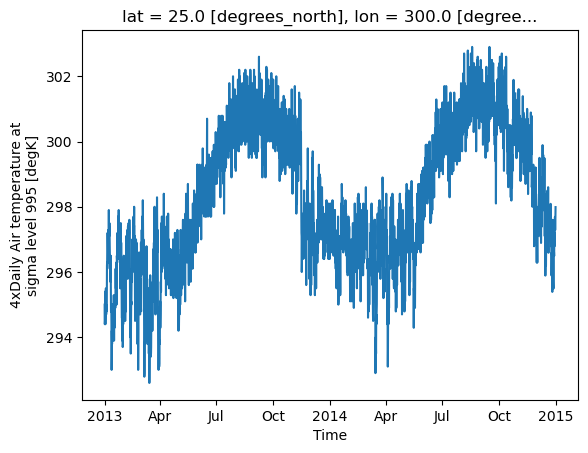

In [11]:
# position indexing (dimension names)
da.isel(lat = 20, lon = 40).plot()

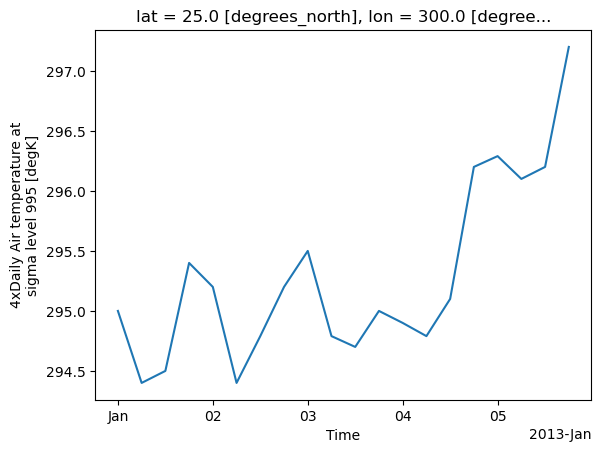

In [12]:
da.isel(time = slice(0, 20), lat=20, lon=40).plot()

### Numpy와 xarray의 indexing 동작 차이
numpy는 좌표 "쌍"을, xarray는 "격자"를 선택한다.

### 1\. NumPy: 'Advanced Indexing' (좌표 쌍 방식)

NumPy는 여러 개의 정수 배열(또는 리스트)로 인덱싱을 할 때, 각 배열의 같은 위치에 있는 요소들을 하나의 **좌표(coordinate)로 묶어서** 값을 선택

`np_array[:, [0, 1], [0, 1]]` 코드 해석.

> "모든 첫 번째 차원에 대해,
>
> 1.  두 번째 차원 인덱스 `0`과 세 번째 차원 인덱스 `0`을 **짝지어** `(0, 0)` 위치의 값을 가져오고,
> 2.  두 번째 차원 인덱스 `1`과 세 번째 차원 인덱스 `1`을 **짝지어** `(1, 1)` 위치의 값을 가져와라."

따라서 각 2920개의 슬라이스마다 **2개의 값**만 선택되므로 최종 결과의 shape는 `(2920, 2)`가 된다.
#### 간단한 예시

```python
arr = np.arange(16).reshape(4, 4)
# NumPy 인덱싱: [0, 2]와 [1, 3]을 짝지음 -> (0, 1)과 (2, 3)을 선택
selection = arr[[0, 2], [1, 3]] 
print("\nNumPy Selection:", selection) # [ 1 11]
print("Shape:", selection.shape)      # (2,)
```

-----

### 2\. Xarray: 'Vectorized Indexing' (격자 방식)

Xarray는 과학 데이터 분석을 위해 설계되었기 때문에, 인덱싱을 할 때 데이터의 **격자 구조를 유지**하는 것이 목표. 여러 차원에 인덱스 목록을 제공하면, Xarray는 각 목록의 \*\*모든 조합(combination)\*\*에 해당하는 데이터들을 선택하여 새로운 '부분 격자'를 만듭니다.

`da[:, [0, 1], [0, 1]]` 코드는

> "모든 첫 번째 차원에 대해,
>
> 1.  두 번째 차원의 인덱스가 `0` 또는 `1`인 모든 데이터와,
> 2.  세 번째 차원의 인덱스가 `0` 또는 `1`인 모든 데이터를 \*\*모두 포함하는 사각형 영역(부분 격자)\*\*을 가져와라."

따라서 각 2920개의 슬라이스마다 `(2x2)` 크기의 배열이 선택되므로 최종 결과의 shape는 `(2920, 2, 2)`가 된다.

#### 간단한 예시

```python
da = xr.DataArray(arr, dims=['y', 'x'])
selection = da[[0, 2], [1, 3]]
print("\nXarray Selection:\n", selection.values)
# [[ 1  3]
#  [ 9 11]]
print("Shape:", selection.shape) # (2, 2)
```

-----

### 핵심 요약: 점 vs. 사각형 📌

  * **NumPy (Advanced Indexing)**: 지도에서 `(위도1, 경도1)`, `(위도2, 경도2)`와 같이 특정 **점(point)들**을 콕콕 찍어서 가져오는 방식이다.
  * **Xarray (Vectorized Indexing)**: 지도에서 '위도는 A부터 B까지, 경도는 C부터 D까지'에 해당하는 \*\*사각형 영역(rectangle)\*\*을 통째로 잘라내는 방식이다.

In [13]:
np_array[:, [0, 1], [0, 1]].shape

(2920, 2)

In [14]:
da[:, [0, 1], [0, 1]].shape

(2920, 2, 2)

In [15]:
np_array[:, [0, 1, 2, 3, 4, 5], [5, 6, 7, 8, 9, 10]].shape

(2920, 6)

In [18]:
da[:, 0:7, 5:12].shape

(2920, 7, 7)

In [19]:
selected_da = da.isel(lat = slice(0, 7), lon = slice(5, 12))
print(selected_da)

<xarray.DataArray 'air' (time: 2920, lat: 7, lon: 7)> Size: 1MB
243.9 243.6 243.1 242.5 241.9 241.2 ... 275.5 274.7 274.1 273.8 273.1 271.8
Coordinates:
  * lat      (lat) float32 28B 75.0 72.5 70.0 67.5 65.0 62.5 60.0
  * lon      (lon) float32 28B 212.5 215.0 217.5 220.0 222.5 225.0 227.5
  * time     (time) datetime64[ns] 23kB 2013-01-01 ... 2014-12-31T18:00:00
Attributes: (11)


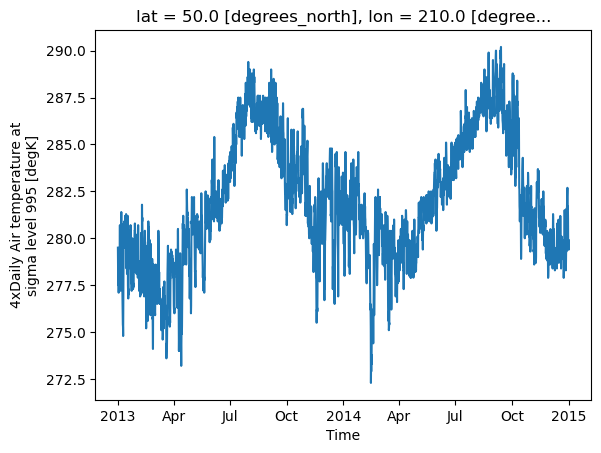

In [ ]:
# 1차원으로 축소된 데이터 (2개 차원을 점으로 선택) → 선 그래프
# lat과 lon을 "점"으로 선택 → time 차원만 남음
da.sel(lat=50, lon=210, method='nearest').plot()

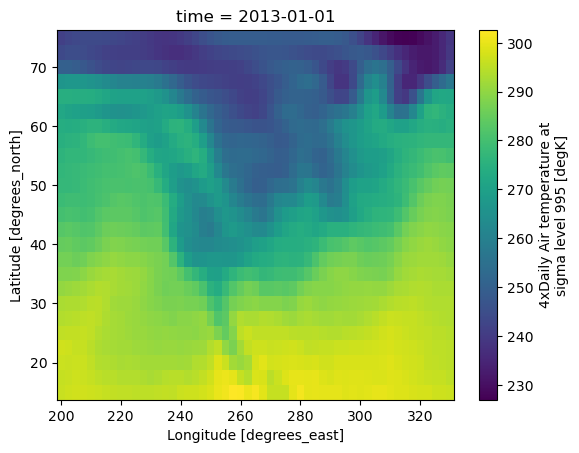

In [29]:
# 2차원 데이터 (lat, lon만 있음) → heatmap
# time을 "점"으로 선택 → lat, lon 차원만 남음
da.isel(time=0).plot()

(array([   65.,  1004.,  4517.,  9538., 11894., 13921., 14906., 19158.,
        18011.,  3346.]),
 array([272.29 , 275.061, 277.832, 280.603, 283.374, 286.145, 288.916,
        291.687, 294.458, 297.229, 300.   ]),
 <BarContainer object of 10 artists>)

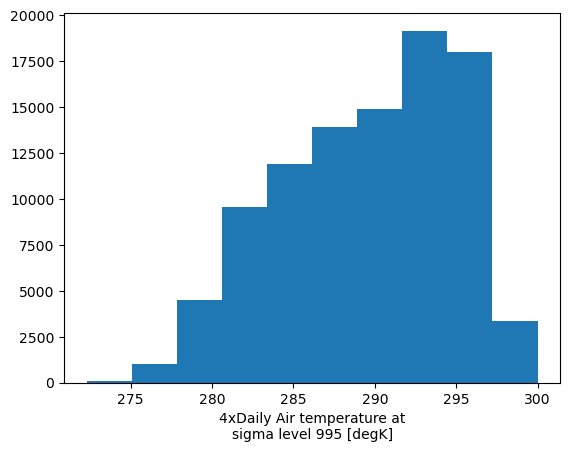

In [28]:
# 3차원 데이터 (time, lat, lon 모두 있음) → 히스토그램
# 모든 차원을 "범위"로 선택 → 3차원 유지
da.sel(lat=slice(50, 25), lon=slice(210, 215)).plot()


In [30]:
# dropping using drop_sel
# we want to drop it/? we can use drop_sel method!

da.drop_sel(lat=50.0, lon=200.0)

<xarray.DataArray 'air' (time: 2920, lat: 24, lon: 52)> Size: 29MB
242.5 243.5 244.0 244.1 243.9 243.6 ... 297.9 297.4 297.2 296.5 296.2 295.7
Coordinates:
  * lat      (lat) float32 96B 75.0 72.5 70.0 67.5 65.0 ... 22.5 20.0 17.5 15.0
  * lon      (lon) float32 208B 202.5 205.0 207.5 210.0 ... 325.0 327.5 330.0
  * time     (time) datetime64[ns] 23kB 2013-01-01 ... 2014-12-31T18:00:00
Attributes: (11)

In [31]:
# Nearest Neighbor Lookups
# we can use nearest, pad, backfill

da.sel(lat=52.25, lon=251.8998, method = "nearest")

<xarray.DataArray 'air' (time: 2920)> Size: 23kB
262.7 263.2 270.9 274.1 273.3 270.6 ... 247.3 253.4 261.6 264.2 265.2 267.0
Coordinates:
    lat      float32 4B 52.5
    lon      float32 4B 252.5
  * time     (time) datetime64[ns] 23kB 2013-01-01 ... 2014-12-31T18:00:00
Attributes: (11)

In [32]:
# tolerance : limits the maximum distance for valid matches
da.sel(lat=52.25, lon=251.8998, method = "nearest", tolerance=2)

<xarray.DataArray 'air' (time: 2920)> Size: 23kB
262.7 263.2 270.9 274.1 273.3 270.6 ... 247.3 253.4 261.6 264.2 265.2 267.0
Coordinates:
    lat      float32 4B 52.5
    lon      float32 4B 252.5
  * time     (time) datetime64[ns] 23kB 2013-01-01 ... 2014-12-31T18:00:00
Attributes: (11)